# Indices Mosaic Notebook

Notebook to allow generation of mosaics using Indices - Indicies include Normalise Difference Vegetation Index (NDVI), Enhanced Vegetation Index (EVI) and Normalised Difference Water Index (NDWI). 


In [101]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import xarray as xr 
from shapely import wkt
from datetime import datetime
import datacube
from matplotlib.cm import RdYlGn, Greens, Blues

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
#import datacube utilities
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
from utils_dcal.data_cube_utilities.dc_display_map import display_map
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic, create_min_ndvi_mosaic
from utils_dcal.data_cube_utilities.dc_utilities import write_geotiff_from_xr
from utils_dcal.data_cube_utilities.dc_water_quality import tsm
from utils_sac.createAOI import create_lat_lon
from utils_sac.createindices import NDVI, NDWI, EVI
from utils_sac.clean_mask import landsat_qa_clean_mask



In [103]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='indices mosaic')

## Set variables

In [104]:
#area of interest: load in as wkt
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"

In [105]:
#Set- projection: This is the same for all of FIJI so this may not need to be a variable within the Fijian cube.
output_projection = "EPSG:32760"

In [106]:
#set resolution_ if using Landsat min 30, if sentinel min 10
res = 30

In [107]:
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform = 'LANDSAT_4'

In [108]:
#select a single time range for query
time_range = (datetime(1990,1,1), datetime(1995,2,1))

In [109]:
# Select the cloud-free mosaic type
# Options are: max, median, most_recent_pixel, min, mean
mosaic_type = "max"

In [110]:
#indices type
#Options include evi, ndvi, ndwi
indices = EVI

## Create AOI

In [112]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [113]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [114]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

In [ ]:
#create resolution
resolution = (-res, res)

In [115]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}

In [116]:
loaded_ds = dc.load(
    time = time_range,
    **query
)

### Check if loads are valid

In [117]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [118]:
if is_dataset_empty(loaded_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

## Create cloud mask

In [119]:
#create cloud mask
clean_mask = landsat_qa_clean_mask(loaded_ds, platform)

In [120]:
loaded_ds = loaded_ds.where(clean_mask)

## Perform Mosaic

In [129]:
mosaic_function = {"median": create_median_mosaic,
                   "max": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic,
                   "mean": create_mean_mosaic,
                   "min": create_min_ndvi_mosaic
                  }

In [130]:
mosaic_compositor = mosaic_function[mosaic_type]

In [131]:
mosaiced_composite = mosaic_compositor(loaded_ds, clean_mask = clean_mask)

## Calculate Indices and Plot

In [132]:
indices_composite = indices(mosaiced_composite)

In [133]:
print(indices_composite)

<xarray.DataArray (y: 261, x: 213)>
array([[-0.42917 , -0.2798  , -0.11898 , ..., -0.101404, -0.017292, -0.101404],
       [-0.221864, -0.221864, -0.115541, ..., -0.120237, -0.14051 , -0.209948],
       [-0.176838, -0.174736, -0.139192, ..., -0.14051 , -0.14051 , -0.14051 ],
       ...,
       [-0.205826, -0.205826, -0.234282, ...,  0.018837,  0.017048, -0.013127],
       [-0.205826, -0.138652, -0.19027 , ..., -0.012488, -0.022266,  0.016247],
       [-0.138652, -0.138652, -0.118873, ..., -0.010435, -0.010878,  0.016247]])
Coordinates:
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05


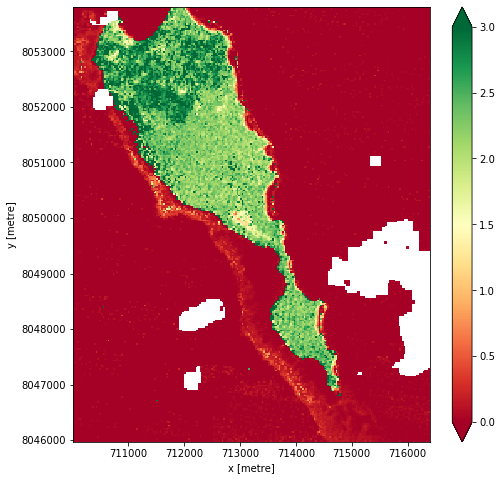

In [134]:
plt.figure(figsize = (8,8))
if indices in [NDVI]:
    indices_composite.plot(vmin=0, vmax=1, cmap = RdYlGn)
elif indices in [NDWI]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = Blues)
elif indices in [EVI]:
    indices_composite.plot(vmin=0, vmax=3, cmap = RdYlGn)
else:
    print('indicies invalid')


In [136]:
xr.DataArray.to_dataset(indices_composite, dim = None, name = 'ndvi')

<xarray.Dataset>
Dimensions:  (x: 213, y: 261)
Coordinates:
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
Data variables:
    ndvi     (y, x) float64 -0.4292 -0.2798 -0.119 ... -0.01044 -0.01088 0.01625

In [137]:
write_geotiff_from_xr('indices_composite.tiff', indices_composite, ["ndvi"], crs=output_projection, x_coord = 'x', y_coord = 'y')